# Data Preprocessing

In [1]:
import re
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# Importar a base de dados
df_apts = pd.read_csv('links_apartamentos.csv')
print(df_apts.info())
df_apts.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3981 entries, 0 to 3980
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   link         3981 non-null   object 
 1   valor        3968 non-null   object 
 2   condominio   3981 non-null   object 
 3   iptu         3981 non-null   object 
 4   quartos      3981 non-null   float64
 5   tamanho      3981 non-null   float64
 6   vagas        3981 non-null   object 
 7   banheiros    3981 non-null   float64
 8   andar        3981 non-null   object 
 9   mobilia      3981 non-null   object 
 10  localização  3967 non-null   object 
dtypes: float64(3), object(8)
memory usage: 342.2+ KB
None


,link,valor,condominio,iptu,quartos,tamanho,vagas,banheiros,andar,mobilia,localização
0,https://www.quintoandar.com.br/imovel/89444181...,389.000,450,12x R$ 62,2.0,86.0,2.0,2.0,4° a 7° andar,Sem mobília,"22.9351007,-47.0598796"
1,https://www.quintoandar.com.br/imovel/89376445...,395.000,380,12x R$ 101,2.0,110.0,2.0,3.0,4° a 7° andar,Sem mobília,"-22.9329903,-47.060889"
2,https://www.quintoandar.com.br/imovel/89351341...,315.000,500,12x R$ 50,2.0,82.0,1.0,2.0,8° a 11° andar,Sem mobília,"-22.9163209,-47.044068"
3,https://www.quintoandar.com.br/imovel/89443433...,345.000,16,12x R$ 14,2.0,56.0,1.0,1.0,12° a 15° andar,Sem mobília,"22.9297222,-47.0589482"
4,https://www.quintoandar.com.br/imovel/89438885...,410.000,465,12x R$ 83,2.0,102.0,1.0,2.0,4° a 7° andar,Sem mobília,"22.9305711,-47.0570666"


In [3]:
# Limpar entradas nulas
df_apts.dropna(inplace=True)

In [4]:
# Corrige os tipos de cada coluna
df_apts['valor'] = df_apts['valor'].str.replace('.', '').astype(float)
df_apts['condominio'] = df_apts['condominio'].str.replace('.0', '').str.replace('.', '').astype(float)
df_apts['quartos'] = df_apts['quartos'].astype(int)
df_apts['tamanho'] = df_apts['tamanho'].astype(int)
df_apts['vagas'] = df_apts['vagas'].str.replace('.', '').str.replace('-', '0').astype(int)
df_apts['banheiros'] = df_apts['banheiros'].astype(int)
print(df_apts.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3954 entries, 0 to 3980
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   link         3954 non-null   object 
 1   valor        3954 non-null   float64
 2   condominio   3954 non-null   float64
 3   iptu         3954 non-null   object 
 4   quartos      3954 non-null   int32  
 5   tamanho      3954 non-null   int32  
 6   vagas        3954 non-null   int32  
 7   banheiros    3954 non-null   int32  
 8   andar        3954 non-null   object 
 9   mobilia      3954 non-null   object 
 10  localização  3954 non-null   object 
dtypes: float64(2), int32(4), object(5)
memory usage: 308.9+ KB
None


In [5]:

def extrair_iptu(iptu):              # transforma o texto do IPTU do formato 12x R$ valor para apenas valor no formato float
    match = re.search(r'R\$ (\d+(\.\d+)?)', str(iptu))
    if match:
        return float(match.group(1))
    else:
        return None
df_apts['iptu'] = df_apts['iptu'].apply(extrair_iptu)

def extrair_localizacao(localizacao):# corrige as entradas de latitude e longitude caso estejam sem o sinal negativo no começo
    match = re.search(r'(\d+\.\d+,-?\d+\.\d+)', str(localizacao))
    if match:
        return "-" + match.group(1)
    else:
        return None
df_apts['localização'] = df_apts['localização'].apply(extrair_localizacao)

def extrair_andar_medio(andar):      #  transforma o texto de andar que fornece um intervalo de possiveis andares par a média deles
    if '-' in andar: return 0
    elif 'Até' in andar:
        numero = re.search(r'Até (\d+)° andar', andar)
        return float(numero.group(1))/2 + 0.5
    elif 'a' in andar:
        numeros = re.search(r'(\d{1,2})° a (\d{1,2})°', andar)
        return (float(numeros.group(1))+float(numeros.group(2)))/2
df_apts['andar'] = df_apts['andar'].apply(extrair_andar_medio)

df_apts['mobilia'] = df_apts['mobilia'].replace({'Sem mobília': 0, 'Mobiliado': 1})   # transoforma as entradas de mobilia para 0 ou 1
def extrair_bairro(link):    # cria a coluna bairro com base na informação presente no final do link
    if 'quartos-' in link:
        return link.split('quartos-')[1].replace('-', ' ')
    elif 'quarto-' in link:
        return link.split('quarto-')[1].replace('-', ' ')
    else:
        return None  # Ou qualquer tratamento que você deseja fazer para casos inesperados
df_apts['bairro'] = df_apts['link'].apply(extrair_bairro)

# Extrair as coordenadas de latitude e longitude da coluna 'localização'
df_apts[['latitude', 'longitude']] = df_apts['localização'].str.split(',', expand=True).astype(float)
df_apts.dropna(subset=['latitude'],inplace=True)
df_apts.head()

C:\Users\Bianchi\AppData\Local\Temp\ipykernel_11032\861371774.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_apts['mobilia'] = df_apts['mobilia'].replace({'Sem mobília': 0, 'Mobiliado': 1})   # transoforma as entradas de mobilia para 0 ou 1


,link,valor,condominio,iptu,quartos,tamanho,vagas,banheiros,andar,mobilia,localização,bairro,latitude,longitude
0,https://www.quintoandar.com.br/imovel/89444181...,389000.0,450.0,62.0,2,86,20,2,5.5,0,"-22.9351007,-47.0598796",jardim nova europa campinas,-22.935101,-47.059880
1,https://www.quintoandar.com.br/imovel/89376445...,395000.0,380.0,101.0,2,110,20,3,5.5,0,"-22.9329903,-47.060889",jardim nova europa campinas,-22.932990,-47.060889
2,https://www.quintoandar.com.br/imovel/89351341...,315000.0,500.0,50.0,2,82,10,2,9.5,0,"-22.9163209,-47.044068",jardim proenca campinas,-22.916321,-47.044068
3,https://www.quintoandar.com.br/imovel/89443433...,345000.0,16.0,14.0,2,56,10,1,13.5,0,"-22.9297222,-47.0589482",jardim nova europa campinas,-22.929722,-47.058948
4,https://www.quintoandar.com.br/imovel/89438885...,410000.0,465.0,83.0,2,102,10,2,5.5,0,"-22.9305711,-47.0570666",jardim nova europa campinas,-22.930571,-47.057067


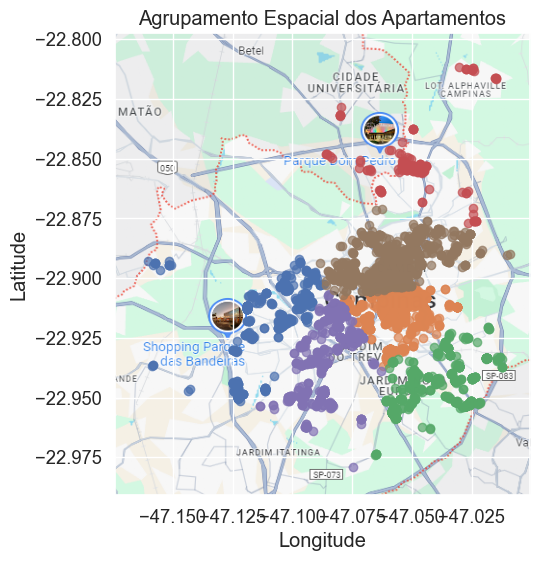

In [25]:
# Aplicar o algoritmo K-means
n_clusters = 6  # Escolha o número de clusters (grupos)
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
df_apts['região'] = kmeans.fit_predict(df_apts[['latitude', 'longitude']])

# Plotar os grupos
plt.figure(figsize=(10, 6))
for cluster in range(n_clusters):
    cluster_data = df_apts[df_apts['região'] == cluster]
    plt.scatter(cluster_data['longitude'], cluster_data['latitude'], label=f'Cluster {cluster}', alpha=0.7)
# Carregar a imagem da cidade de Campinas
img = mpimg.imread('campinas.png')
# Plotar a imagem
plt.imshow(img, extent=[-47.174337, -47.000437, -22.990840, -22.797463])

# Adicionar título e rótulos dos eixos
plt.title('Agrupamento Espacial dos Apartamentos')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Mostrar o plot
plt.show()

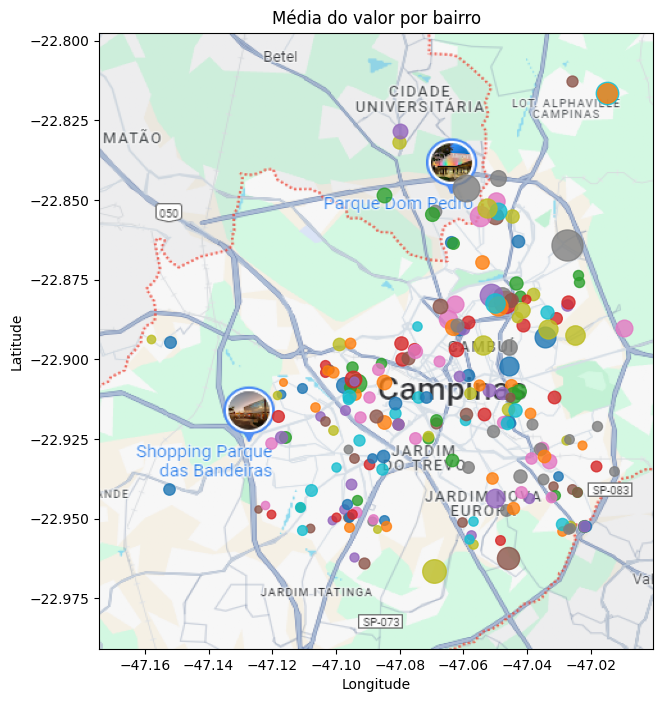

In [7]:
import matplotlib.pyplot as plt

# Calcular a média do valor por bairro
media_por_bairro = df_apts.groupby('bairro')['valor'].mean()

# Plotar os círculos
plt.figure(figsize=(10, 8))

# Carregar a imagem da cidade de Campinas
img = mpimg.imread('campinas.png')
# Plotar a imagem
plt.imshow(img, extent=[-47.174337, -47.000437, -22.990840, -22.797463])

# Iterar sobre cada bairro
for bairro, media_valor in media_por_bairro.items():
    # Obter as coordenadas do centroide do bairro
    latitude = df_apts[df_apts['bairro'] == bairro]['latitude'].mean()
    longitude = df_apts[df_apts['bairro'] == bairro]['longitude'].mean()
    
    # Definir o tamanho do círculo proporcional à média do valor
    tamanho_circulo = media_valor / media_por_bairro.max() * 500
    
    # Plotar o círculo
    plt.scatter(longitude, latitude, s=tamanho_circulo, alpha=0.8, label=bairro)

# Adicionar legendas e rótulos
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Média do valor por bairro')
# plt.legend()

# Exibir o plot
plt.show()

In [8]:
df_apts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3932 entries, 0 to 3980
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   link         3932 non-null   object 
 1   valor        3932 non-null   float64
 2   condominio   3932 non-null   float64
 3   iptu         3932 non-null   float64
 4   quartos      3932 non-null   int32  
 5   tamanho      3932 non-null   int32  
 6   vagas        3932 non-null   int32  
 7   banheiros    3932 non-null   int32  
 8   andar        3932 non-null   float64
 9   mobilia      3932 non-null   int64  
 10  localização  3932 non-null   object 
 11  bairro       3932 non-null   object 
 12  latitude     3932 non-null   float64
 13  longitude    3932 non-null   float64
 14  região       3932 non-null   int32  
dtypes: float64(6), int32(5), int64(1), object(3)
memory usage: 414.7+ KB


# Feature Selection

Common approaches for feature selection:
- Filter methods
    - Pearson correlation coefficient
    - Chi-square coefficient (Classification)
    - Mutual information
- Wrapper methods 
    - Forward Selection
    - Backward Elimination
    - Recursive feature elimination (RFE)
- Embedded methods
    - Regularization method (Lasso regression)

## Matriz de Correlação
O coeficiente de correlação de Pearson é uma medida estatística que avalia a relação linear entre duas variáveis contínuas

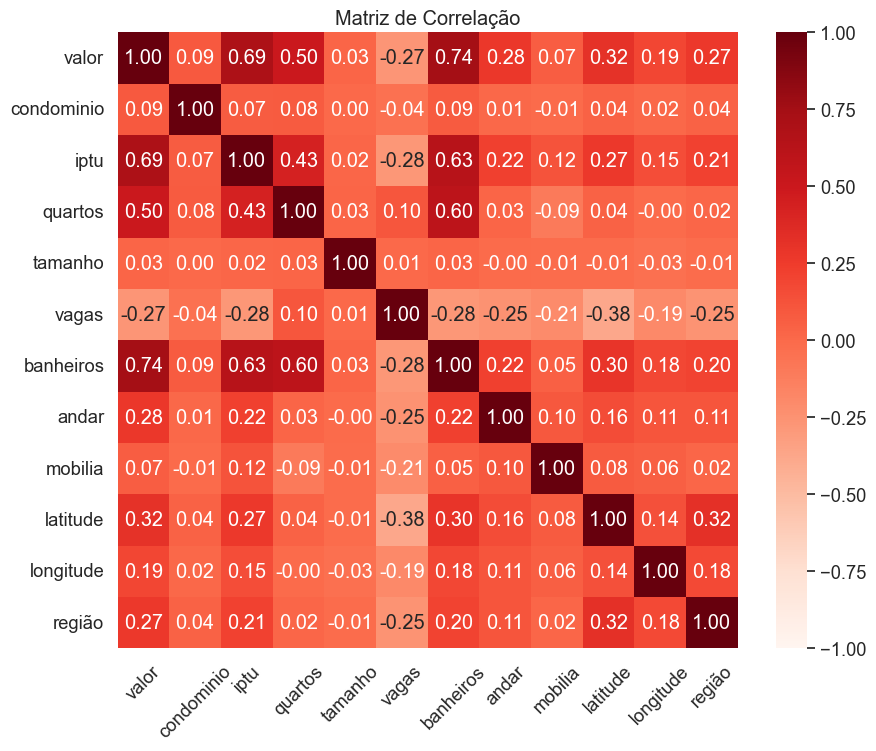

In [26]:
import pandas as pd
import seaborn as sns

df_apts_num = df_apts.drop(columns=['link','bairro','localização'])

# Calcule a matriz de correlação de Pearson
correlation_matrix = df_apts_num.corr()
# Configure o estilo do heatmap
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(correlation_matrix, cmap='Reds', annot=True, fmt=".2f", vmin=-1, vmax=1)

# Adicione um título
plt.title('Matriz de Correlação')

# Rotacione os rótulos dos eixos x e y para melhor visualização
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Exiba o plot
plt.show()

In [10]:
df_apts_num.describe()

,valor,condominio,iptu,quartos,tamanho,vagas,banheiros,andar,mobilia,latitude,longitude,região
count,3.932000e+03,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000
mean,4.216484e+05,731.928026,93.611297,2.173194,88.170397,5.091811,1.595371,5.185656,0.173703,-22.913951,-47.064444,0.940997
std,3.614437e+05,4076.960585,107.365697,0.759080,824.506899,4.802692,0.863523,4.596307,0.378902,0.023465,0.023562,0.658836
min,1.330000e+05,0.000000,0.000000,1.000000,24.000000,0.000000,1.000000,0.000000,0.000000,-22.979194,-47.160438,0.000000
25%,2.250000e+05,352.750000,30.000000,2.000000,50.000000,1.000000,1.000000,2.000000,0.000000,-22.930492,-47.077902,1.000000
50%,3.000000e+05,494.000000,62.000000,2.000000,63.000000,2.000000,1.000000,2.000000,0.000000,-22.910970,-47.059100,1.000000
75%,4.700000e+05,690.000000,113.000000,3.000000,84.000000,10.000000,2.000000,5.500000,0.000000,-22.900324,-47.051721,1.000000
max,4.280000e+06,165000.000000,957.000000,8.000000,51708.000000,50.000000,8.000000,81.500000,1.000000,-22.811773,-47.009108,2.000000


In [27]:
df_apts_num.corr()['valor'].sort_values(ascending=False)

valor         1.000000
banheiros     0.743915
iptu          0.692294
quartos       0.504415
latitude      0.317203
andar         0.277922
região        0.267307
longitude     0.190624
condominio    0.093382
mobilia       0.065751
tamanho       0.027029
vagas        -0.269854
Name: valor, dtype: float64

As Features vagas, tamanho, mobilia e condominio tiveram uma correlação baixa com o target value

A região com 6 clusters mostrou ser a divisão que possui a melor correlação com o valor

Latitude e Longitude podem ser consideradas redundantes devido a feature regiao

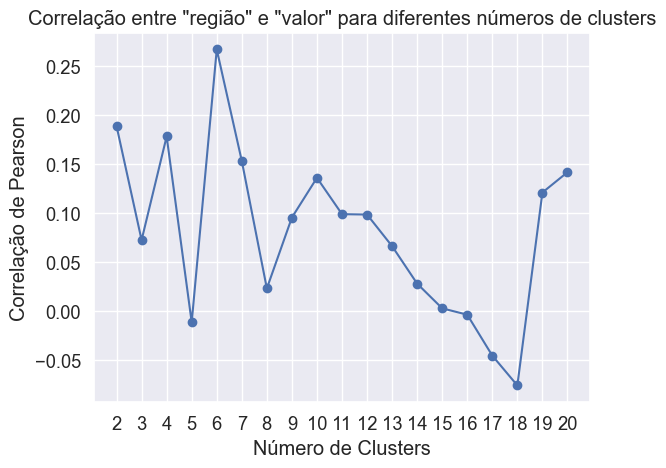

In [11]:
import numpy as np
import pandas as pd

# Definir numero de clusters a testar
ranges = range(2, 21)

correlation_values = []

# Para cada número de clusters, calcule o coeficiente de correlação de Pearson
for n_clusters in ranges:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    df_apts['região'] = kmeans.fit_predict(df_apts[['latitude', 'longitude']])
   
    # Calcule o coeficiente de correlação de Pearson entre 'região' e 'valor'
    correlation = df_apts['região'].corr(df_apts['valor'])
    correlation_values.append(correlation)

# Plotar os valores de correlação em função do número de clusters
plt.plot(ranges, correlation_values, marker='o')
plt.xticks(ranges)
plt.xlabel('Número de Clusters')
plt.ylabel('Correlação de Pearson')
plt.title('Correlação entre "região" e "valor" para diferentes números de clusters')
plt.grid(True)
plt.show()

## Mutual Information
A informação mútua é uma medida estatística que quantifica a dependência mútua entre duas variáveis. No contexto de seleção de features, a informação mútua pode ser usada para medir o quanto uma feature é informativa sobre a variável alvo.

In [12]:
from sklearn.feature_selection import mutual_info_regression

X = df_apts[['condominio','iptu','quartos', 'tamanho', 'vagas', 'banheiros', 'andar', 'mobilia','latitude','longitude','região']]
y = df_apts['valor']

# Calcule a informação mútua entre cada feature e a variável alvo
mi_scores = mutual_info_regression(X, y)

# Crie um DataFrame para visualização dos resultados
mi_scores_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi_scores})

# Ordene os resultados por ordem decrescente de informação mútua
mi_scores_df = mi_scores_df.sort_values(by='Mutual Information', ascending=False)

mi_scores_df

,Feature,Mutual Information
0,condominio,0.527846
4,vagas,0.488607
1,iptu,0.481428
5,banheiros,0.391508
8,latitude,0.359216
3,tamanho,0.344254
9,longitude,0.324168
10,região,0.287710
2,quartos,0.227410
6,andar,0.076026


As features mobilia, regiao, quartos e andar mostraram ser pouco informativas para a definição do valor do imóvel

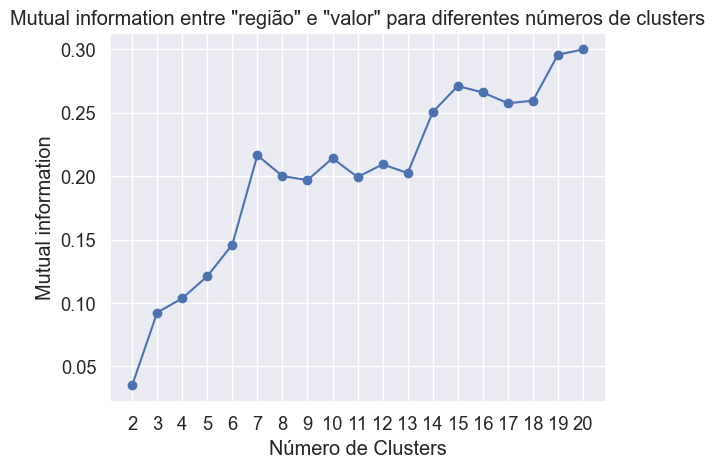

In [13]:
ranges = range(2, 21)

mutual_info_values = []

# Para cada número de clusters, calcule o Mutual Information
for n_clusters in ranges:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    df_apts['região'] = kmeans.fit_predict(df_apts[['latitude', 'longitude']])
    X = df_apts[['condominio','iptu','quartos', 'tamanho', 'vagas', 'banheiros', 'andar', 'mobilia','latitude','longitude','região']]
    y = df_apts['valor']

    # Calcule a informação mútua entre cada feature e a variável alvo
    mi_scores = mutual_info_regression(X, y)

    # Calcule o Mutual Information entre 'região' e 'valor'
    mutual_info = mi_scores[10]
    mutual_info_values.append(mutual_info)

# Plotar os valores de correlação em função do número de clusters
plt.plot(ranges, mutual_info_values, marker='o')
plt.xticks(ranges)
plt.xlabel('Número de Clusters')
plt.ylabel('Mutual information')
plt.title('Mutual information entre "região" e "valor" para diferentes números de clusters')
plt.grid(True)
plt.show()

O aumento no numero de clusters separando as regiões aumenta a informação da feature região. 

O numero de clusters 7 pode ser uma boa opção além do 6

## Forward Selection
O método de seleção de features Forward Selection é uma abordagem iterativa que começa sem features no modelo e adiciona uma a uma, escolhendo aquela que mais melhora o desempenho do modelo.

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = df_apts[['condominio','iptu','quartos', 'tamanho', 'vagas', 'banheiros', 'andar', 'mobilia','latitude','longitude','região']]
y = df_apts['valor']

# Inicialize um conjunto vazio de features selecionadas
selected_features = []

# Inicialize o modelo
model = LinearRegression()

# Número total de features
total_features = len(X.columns)

# Loop para selecionar as features
for i in range(total_features):
    best_feature = None
    best_performance = float('inf')
    
    # Para cada feature não selecionada
    for feature in X.columns:
        if feature not in selected_features:
            # Adicione temporariamente a feature ao conjunto de features selecionadas
            temp_selected_features = selected_features + [feature]
            
            # Treine o modelo usando apenas as features selecionadas temporariamente
            model.fit(X[temp_selected_features], y)
            
            # Avalie o desempenho do modelo
            y_pred = model.predict(X[temp_selected_features])
            performance = mean_squared_error(y, y_pred)
            print(performance)
            
            # Se o desempenho do modelo melhorar com a adição da nova feature
            if performance < best_performance:
                print(f'a feature {feature} melhorou o modelo')
                best_performance = performance
                best_feature = feature
            else: print(f'a feature {feature} não melhorou o modelo')
    # Adicione permanentemente a melhor feature ao conjunto de features selecionadas
    selected_features.append(best_feature)

# Resultado final das melhores features
print("Melhores features selecionadas:", selected_features)
print("Features não selecionadas:", [item for item in list(X.columns) if item not in selected_features])

129469423003.57268
a feature condominio melhorou o modelo
68011529078.293686
a feature iptu melhorou o modelo
97377102245.90114
a feature quartos não melhorou o modelo
130512928646.50484
a feature tamanho não melhorou o modelo
121097293009.11331
a feature vagas não melhorou o modelo
58328445820.36014
a feature banheiros melhorou o modelo
120520107913.24385
a feature andar não melhorou o modelo
130043694976.57797
a feature mobilia não melhorou o modelo
117466842253.08272
a feature latitude não melhorou o modelo
125862378783.50893
a feature longitude não melhorou o modelo
127981768872.259
a feature região não melhorou o modelo
58211848376.949615
a feature condominio melhorou o modelo
47528139995.64119
a feature iptu melhorou o modelo
57618214312.36524
a feature quartos não melhorou o modelo
58321619296.27919
a feature tamanho não melhorou o modelo
57795411476.64379
a feature vagas não melhorou o modelo
56527033984.15039
a feature andar não melhorou o modelo
58208573722.855804
a feature m

O método Forward selection selecionou todas as features como úteis para o desempenho do modelo

Essa analise deve ser refeita posteriormente com um modelo melhor

## Regularização Lasso 
O método de regularização Lasso (Least Absolute Shrinkage and Selection Operator) é uma técnica de regressão linear que adiciona uma penalidade L1 à função de custo, forçando os coeficientes de algumas features a serem exatamente zero. Isso permite a seleção automática de features, tornando-as não influentes para o modelo.

In [67]:
from sklearn.linear_model import Lasso

X = df_apts_num.drop(columns=['valor'])
y = df_apts['valor']

# Instancie o modelo Lasso com o parâmetro de regularização alpha
lasso_model = Lasso(alpha=0.01)  # Você pode ajustar o valor de alpha conforme necessário

# Treine o modelo usando os dados de treinamento
lasso_model.fit(X, y)

# Obtenha os coeficientes das features
coefficients = lasso_model.coef_

# Selecione as features com coeficientes não nulos como as melhores features
best_features = X.columns[coefficients != 0]

# Resultado final das melhores features
print("Melhores features selecionadas:", best_features)
print("Features não selecionadas:", [item for item in list(X.columns) if item not in best_features])

Melhores features selecionadas: Index(['condominio', 'iptu', 'quartos', 'tamanho', 'vagas', 'banheiros',
       'andar', 'mobilia', 'latitude', 'longitude', 'região'],
      dtype='object')
Features não selecionadas: []


O metodo Lasso Regression (alpha = 0.1) considerou todas a features influentes para o modelo

Essa analise deve ser refeita com um valor otimizado de alpha

Conclusão:

As melhores features para o modelo sao ['valor', 'banheiros', 'iptu', 'quartos', 'andar', 'regiao']

<Axes: xlabel='valor', ylabel='Density'>

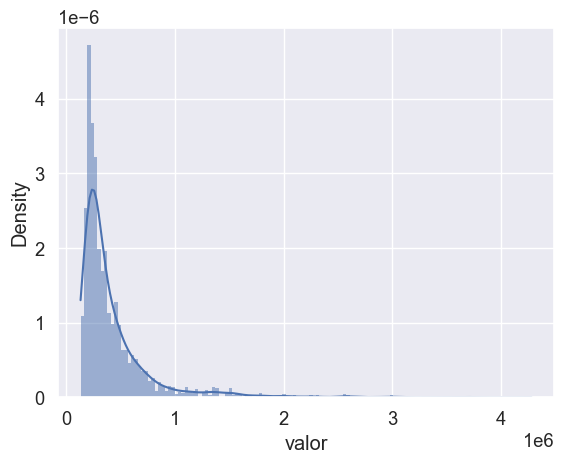

In [126]:
df_model = df_apts.filter(['valor', 'banheiros', 'iptu', 'quartos', 'andar', 'região'])
len(df_model)
sns.histplot(df_model['valor'], kde=True, stat="density", linewidth=0)

# Feature extraction

Approaches for feature extraction:

- Create new features
    - Ex: Feature cross, kernel-tricks...
- Dimensionality reduction techniques
    - Focus on reducing dimensionality by combining existing features into a smaller set of new features
    - Ex: Isomap, UMAP, PCA, Autoencoder, ...

# Finding outliers

In [127]:
def remove_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 3 * iqr
    upper_bound = q3 + 3 * iqr
    
    # Remova as entradas que estão além dos limites
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df_filtered

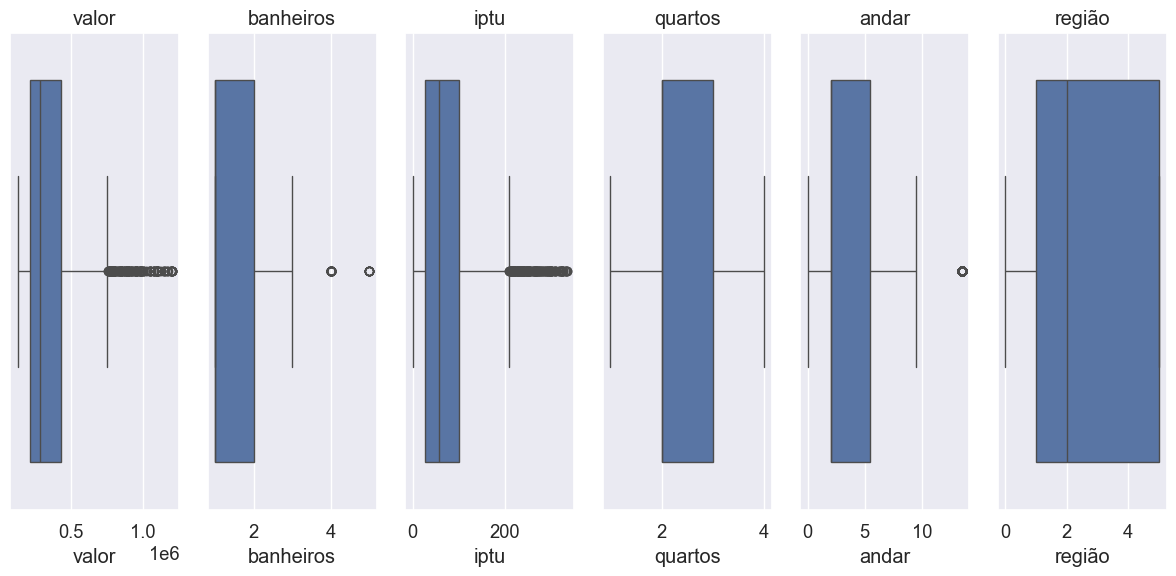

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt

# Lista todas as colunas do DataFrame
columns = df_model.columns

# Define o tamanho da figura
plt.figure(figsize=(12, 6))

# Loop sobre todas as colunas
for col in columns:
    # Cria um subplot para cada coluna
    plt.subplot(1, len(columns), columns.get_loc(col) + 1)
    
    # Plota o boxplot para a coluna atual
    sns.boxplot(x=df_model[col])
    
    # Define o título do subplot como o nome da coluna
    plt.title(col)

# Ajusta o layout para evitar sobreposição
plt.tight_layout()

# Mostra o plot
plt.show()

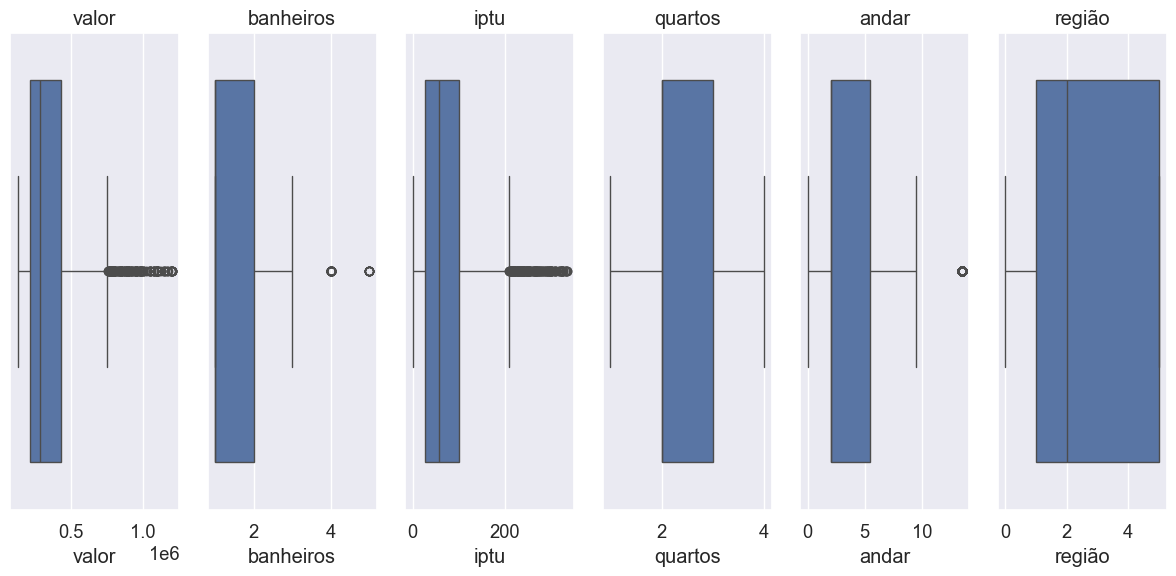

3630

In [129]:
for column in df_model.columns:
    df_model = remove_outliers(df_model, column)

# Lista todas as colunas do DataFrame
columns = df_model.columns

# Define o tamanho da figura
plt.figure(figsize=(12, 6))

# Loop sobre todas as colunas
for col in columns:
    # Cria um subplot para cada coluna
    plt.subplot(1, len(columns), columns.get_loc(col) + 1)
    
    # Plota o boxplot para a coluna atual
    sns.boxplot(x=df_model[col])
    
    # Define o título do subplot como o nome da coluna
    plt.title(col)

# Ajusta o layout para evitar sobreposição
plt.tight_layout()

# Mostra o plot
plt.show()
len(df_model)

In [138]:
df_model.describe()

,valor,banheiros,iptu,quartos,andar,região
count,3.630000e+03,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000
mean,3.553565e+05,1.484298,74.413553,2.116529,4.624380,2.561708
std,1.932585e+05,0.697712,64.697962,0.703436,3.413078,1.854866
min,1.330000e+05,1.000000,0.000000,1.000000,0.000000,0.000000
25%,2.200000e+05,1.000000,27.000000,2.000000,2.000000,1.000000
50%,2.850000e+05,1.000000,58.000000,2.000000,2.000000,2.000000
75%,4.350000e+05,2.000000,100.000000,3.000000,5.500000,5.000000
max,1.200000e+06,5.000000,334.000000,4.000000,13.500000,5.000000


In [137]:
df_model.corr()

,valor,banheiros,iptu,quartos,andar,região
valor,1.000000,0.700830,0.646542,0.462429,0.271243,0.237928
banheiros,0.700830,1.000000,0.558955,0.527844,0.183390,0.134252
iptu,0.646542,0.558955,1.000000,0.352275,0.206916,0.181381
quartos,0.462429,0.527844,0.352275,1.000000,-0.040241,-0.052291
andar,0.271243,0.183390,0.206916,-0.040241,1.000000,0.093882
região,0.237928,0.134252,0.181381,-0.052291,0.093882,1.000000


# Feature scaling

Two common approaches
- min-max scaling (a.k.a. normalization)
    - Normalize data to the interval [0-1]
- standardization
    - Subtract the mean value and divide by the standard deviation

In [54]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Normalização
norm_scaler = MinMaxScaler()

# Padronização
standard_scaler = StandardScaler()

# Model Training and Evaluation

Os critérios de avaliação que serão utilizados para o modelo de regressão serão:
- Erro Absoluto Médio (MAE - Mean Absolute Error)
- Erro Quadrático Médio (MSE - Mean Squared Error)

Será usado o método k-fold cross-validation com 5 folds e um conjunto de teste composto por 10% do total, pois o modelo não deve ser muito complexo.

Caso o modelo aumente sua complexidade, é recomendado aumentar o conjunto de teste para até 30%.

In [141]:
from sklearn.model_selection import train_test_split


X = df_model.drop(columns=['valor'])
y = df_model['valor']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Hyperparameters tuning
- Grid search
- Random search
- Bayesian optimization

Gradient Descent Method: iterative optimization approach that gradually tweaks the model parameters  to minimize the cost function over the training set
- Batch Gradient Descent (BGD): At each iteration, uses all training samples to update θ
- Stochastic Gradient Descent (SGD): At each iteration, uses only one randomly selected sample to update θ
- Mini-Batch Gradient Descent (MBGD): At each iteration, uses a subset (mini-batch) of the training samples to update θ

## Linear Regression
- It is usually preferable to have at least a little bit of regularization: Avoid plain LR!
- Make sure you perform feature scaling if using Ridge/Lasso/Elastic Net regression
- Ridge is a good default, but if you suspect only a few features are actually useful, you should prefer Lasso or Elastic Net 
    - Both tend to reduce the useless features' weights down to zero.

Conclusão: 
- O modelo de regressão linear atingiu os melhores resultados utilizando alpha = 56 e Standart scaler
    - MAE: 36.41968025317833
    - MSE: 2127.8780357709843

In [142]:
from sklearn.linear_model import Ridge
from skopt import BayesSearchCV
from skopt.space import Real

X_train_normalized = norm_scaler.fit_transform(X_train)
X_train_standard = standard_scaler.fit_transform(X_train)

# Defina o espaço de busca para o parâmetro alpha
param_space = {'alpha': Real(0.01, 1000, prior='log-uniform')}

# Inicialize o modelo Ridge
ridge = Ridge()

# Inicialize a pesquisa de hiperparâmetros com validação cruzada k-fold para X_train_normalized
opt_normalized = BayesSearchCV(ridge, param_space, cv=5, n_iter=50, random_state=0)
opt_normalized.fit(X_train_normalized, y_train)

# Inicialize a pesquisa de hiperparâmetros com validação cruzada k-fold para X_train_standard
opt_standard = BayesSearchCV(ridge, param_space, cv=5, n_iter=50, random_state=0)
opt_standard.fit(X_train_standard, y_train)

# Inicialize a pesquisa de hiperparâmetros com validação cruzada k-fold para X_train
opt_original= BayesSearchCV(ridge, param_space, cv=5, n_iter=50, random_state=0)
opt_original.fit(X_train, y_train)

# Extrair alphas e scores para X_train_normalized
alphas_normalized = []
scores_normalized = []
for result in opt_normalized.cv_results_['params']:
    alphas_normalized.append(result['alpha'])
    scores_normalized.append(opt_normalized.cv_results_['mean_test_score'][opt_normalized.cv_results_['params'].index(result)])

# Extrair alphas e scores para X_train_standard
alphas_standard = []
scores_standard = []
for result in opt_standard.cv_results_['params']:
    alphas_standard.append(result['alpha'])
    scores_standard.append(opt_standard.cv_results_['mean_test_score'][opt_standard.cv_results_['params'].index(result)])

# Extrair alphas e scores para X_train
alphas_original = []
scores_original = []
for result in opt_original.cv_results_['params']:
    alphas_original.append(result['alpha'])
    scores_original.append(opt_original.cv_results_['mean_test_score'][opt_original.cv_results_['params'].index(result)])


Melhores hiperparâmetros para X_train_normalized: OrderedDict({'alpha': 1.4612652870044})
Melhor score de validação cruzada para X_train_normalized: 0.6335286750271889
Melhores hiperparâmetros para X_train_standard: OrderedDict({'alpha': 56.0217852021217})
Melhor score de validação cruzada para X_train_standard: 0.633554037129348
Melhores hiperparâmetros para X_train: OrderedDict({'alpha': 14.522139393807581})
Melhor score de validação cruzada para X_train: 0.6334851910295368


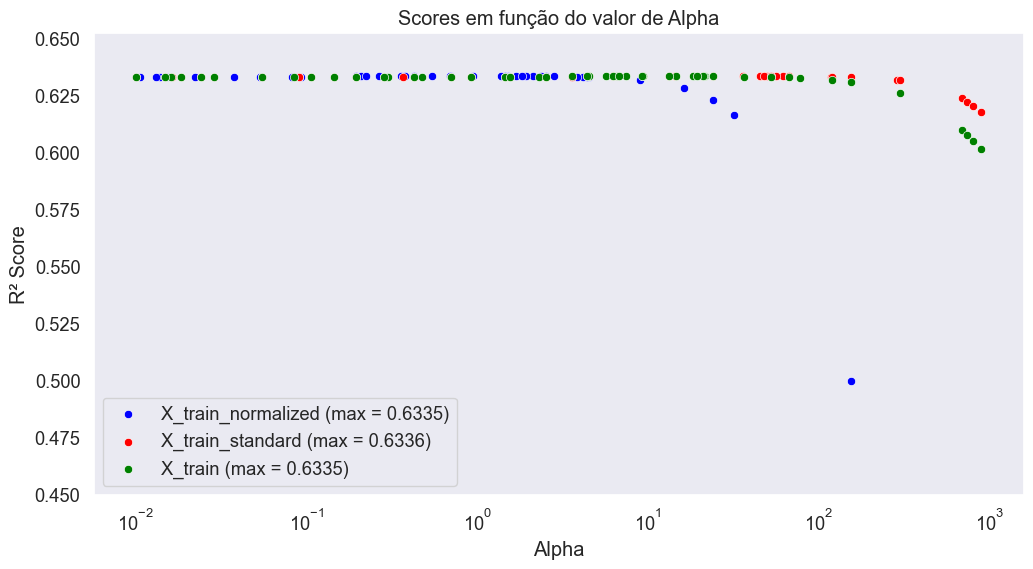

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melhores hiperparâmetros e melores scores encontrados
print("Melhores hiperparâmetros para X_train_normalized:", opt_normalized.best_params_)
print("Melhor score de validação cruzada para X_train_normalized:", opt_normalized.best_score_)
print("Melhores hiperparâmetros para X_train_standard:", opt_standard.best_params_)
print("Melhor score de validação cruzada para X_train_standard:", opt_standard.best_score_)
print("Melhores hiperparâmetros para X_train:", opt_original.best_params_)
print("Melhor score de validação cruzada para X_train:", opt_original.best_score_)

plt.figure(figsize=(12, 6))

# Plotar os scores para X_train_normalized
sns.scatterplot(x=alphas_normalized, y=scores_normalized, label=f'X_train_normalized (max = {max(scores_normalized):.4f})', color='blue')

# Plotar os scores para X_train_standard
sns.scatterplot(x=alphas_standard, y=scores_standard, label=f'X_train_standard (max = {max(scores_standard):.4f})', color='red')

# Plotar os scores para X_train
sns.scatterplot(x=alphas_original, y=scores_original, label=f'X_train (max = {max(scores_original):.4f})', color='green')

plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.title('Scores em função do valor de Alpha')
plt.xscale('log')
plt.ylim(bottom=0.45)
plt.grid()
plt.legend()
plt.show()

In [145]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Inicialize o modelo Ridge com o valor de alpha específico
ridge_model = Ridge(alpha=56)

# Função para realizar a validação cruzada e retornar a média dos scores
def cross_validate_metrics(model, X, y):
    scores_mae = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
    scores_mse = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    return scores_mae.mean(), scores_mse.mean()


# Avalie o modelo usando diferentes conjuntos de dados
mae_train_norm, mse_train_norm = cross_validate_metrics(ridge_model, X_train_standard, y_train)

print("Métricas do modelo Ridge com df_train_norm:")
print("MAE:", mae_train_norm)
print("MSE:", mse_train_norm)

Métricas do modelo Ridge com df_train_norm:
MAE: 80836.21980317365
MSE: 13289803626.040442


## Random Forest

Scikit-learn: max_depth, min_samples_split, min_samples_leaf, min_weight_fraction_leaf, max_leaf_nodes, max_features.

Conclusão:


In [21]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from skopt.space import Real

# Definir o espaço de busca para os hiperparâmetros
param_space = {'max_depth': (1, 30), 'min_samples_split': (2, 30), 'min_samples_leaf': (1, 30)}

# Inicializar o modelo de árvore de decisão
tree = DecisionTreeRegressor(random_state=0)

# Inicializar a pesquisa de hiperparâmetros com validação cruzada k-fold
opt = BayesSearchCV(tree, param_space, cv=5, n_iter=100, random_state=0)

# Executar a pesquisa de hiperparâmetros para X_train
opt.fit(X_train, y_train)

# Extrair os resultados da otimização
results = opt.cv_results_

# Imprimir os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros:")
print(opt.best_params_)

c:\Users\Bianchi\Documents\Python Scripts\personal-projects\Find-a-place\find_a_place\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [10, 30, 30] before, using random point [11, 9, 14]
  warnings.warn(
c:\Users\Bianchi\Documents\Python Scripts\personal-projects\Find-a-place\find_a_place\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [10, 30, 30] before, using random point [23, 8, 15]
  warnings.warn(
c:\Users\Bianchi\Documents\Python Scripts\personal-projects\Find-a-place\find_a_place\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [10, 30, 30] before, using random point [19, 17, 23]
  warnings.warn(
c:\Users\Bianchi\Documents\Python Scripts\personal-projects\Find-a-place\find_a_place\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [10, 30, 30] before,

Melhores hiperparâmetros:
OrderedDict({'max_depth': 24, 'min_samples_leaf': 3, 'min_samples_split': 22})


Melhores hiperparâmetros:
OrderedDict({'max_depth': 24, 'min_samples_leaf': 3, 'min_samples_split': 22})
0.7220951240947447


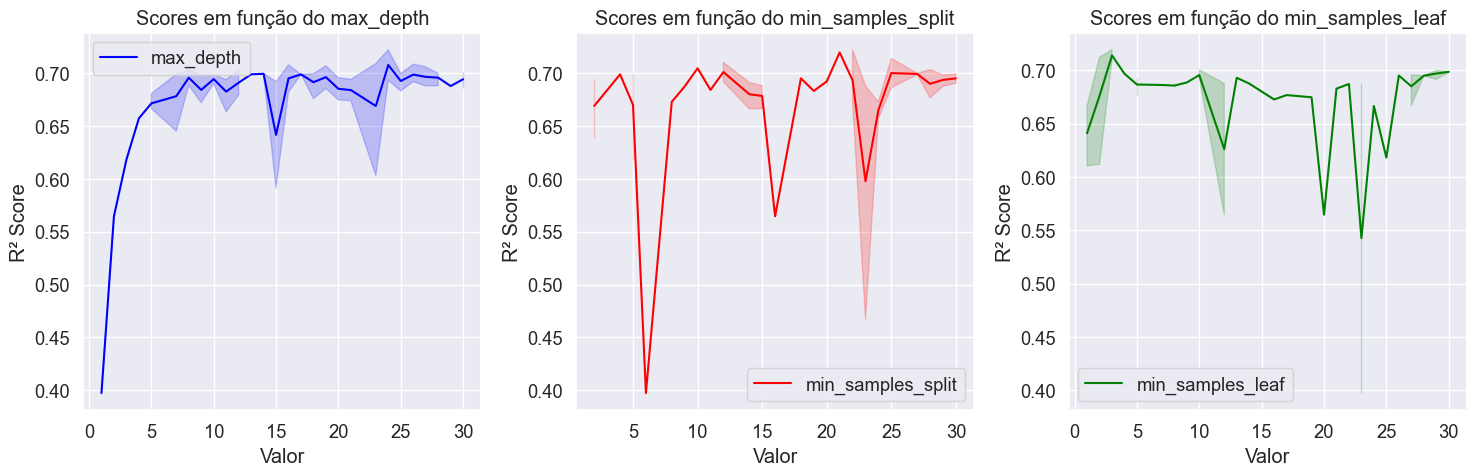

In [22]:
# Extrair alphas e scores para X_train_normalized
max_depth = []
min_samples_split = []
min_samples_leaf = []
scores = []
for result in opt.cv_results_['params']:
    max_depth.append(result['max_depth'])
    min_samples_split.append(result['min_samples_split'])
    min_samples_leaf.append(result['min_samples_leaf'])
    scores.append(opt.cv_results_['mean_test_score'][opt.cv_results_['params'].index(result)])

# Imprimir os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros:")
print(opt.best_params_)
print(opt.best_score_)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plotar os scores para X_train_normalized
sns.lineplot(x=max_depth, y=scores, label='max_depth', color='blue', ax=axes[0])

# Configurações para o subplot 1
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('R² Score')
axes[0].set_title('Scores em função do max_depth')
axes[0].grid(True)
axes[0].legend()

# Plotar os scores para X_train_standard
sns.lineplot(x=min_samples_split, y=scores, label='min_samples_split', color='red', ax=axes[1])

# Configurações para o subplot 2
axes[1].set_xlabel('Valor')
axes[1].set_ylabel('R² Score')
axes[1].set_title('Scores em função do min_samples_split')
axes[1].grid(True)
axes[1].legend()

# Plotar os scores para X_train
sns.lineplot(x=min_samples_leaf, y=scores, label='min_samples_leaf', color='green', ax=axes[2])

# Configurações para o subplot 3
axes[2].set_xlabel('Valor')
axes[2].set_ylabel('R² Score')
axes[2].set_title('Scores em função do min_samples_leaf')
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()
plt.show()

In [146]:
from sklearn.tree import DecisionTreeRegressor

# Inicializar o modelo Decision Tree
tree_model = DecisionTreeRegressor(max_depth= 19, min_samples_leaf= 15, min_samples_split= 18,random_state=0)

# Treinar o modelo
tree_model.fit(X_train, y_train)

# Avaliar o modelo
mae, mse = cross_validate_metrics(tree_model, X_train, y_train)

print("Métricas do modelo Decision Tree:")
print("MAE:", mae)
print("MSE:", mse)

Métricas do modelo Decision Tree:
MAE: 76953.15534764224
MSE: 12614777441.441656


In [148]:
from sklearn.tree import DecisionTreeRegressor

# Inicializar o modelo Decision Tree
tree_model = DecisionTreeRegressor(max_depth= 19, min_samples_leaf= 15, min_samples_split= 18,random_state=0)

# Treinar o modelo
tree_model.fit(X_train, y_train)

# Avaliar o modelo
mae, mse = cross_validate_metrics(tree_model, X_train, y_train)

print("Métricas do modelo Decision Tree:")
print("MAE:", mae)
print("MSE:", mse)

Métricas do modelo Decision Tree:
MAE: 76953.15534764224
MSE: 12614777441.441656


=== LinearRegression() ===


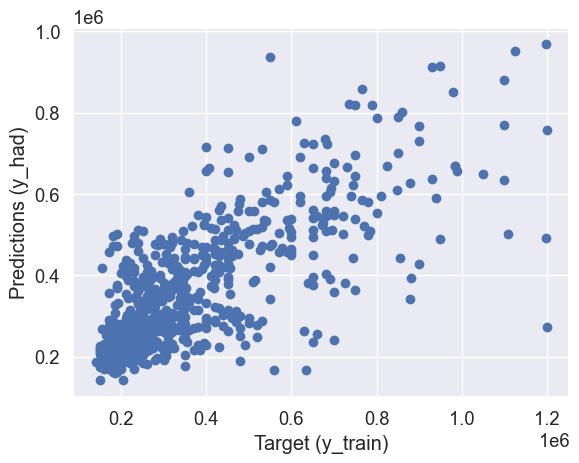

Mean Absolute Error: 89445.89245470075
Mean Squared Error: 17965384977.082752
Root Mean Squared Error: 134035.0139966522
R-squared score 0.24354255085977938
=== RandomForestRegressor() ===


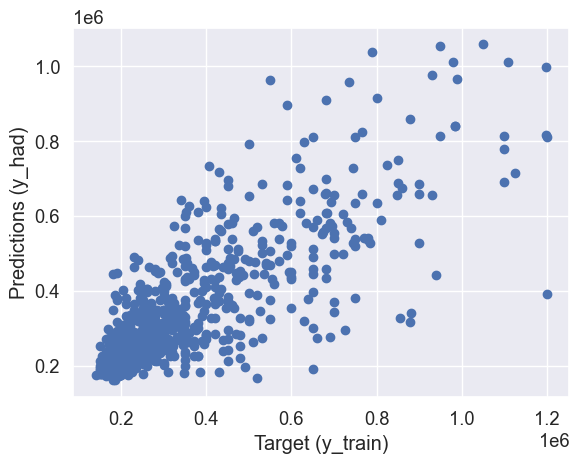

Mean Absolute Error: 84041.7346471156
Mean Squared Error: 15731162239.585472
Root Mean Squared Error: 125423.93009145213
R-squared score 0.45671591375636644
=== DummyRegressor(strategy='median') ===


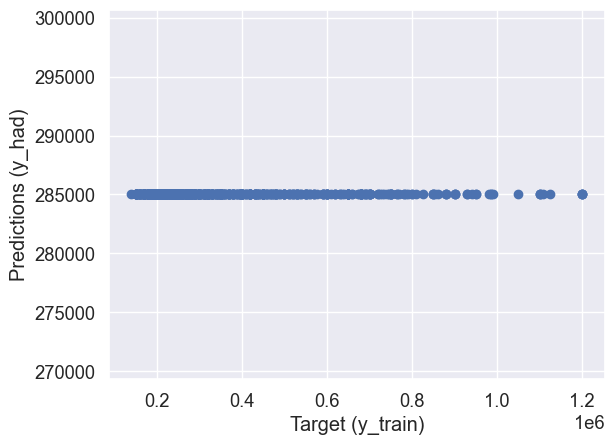

Mean Absolute Error: 142039.84159779616
Mean Squared Error: 47333695986.63499
Root Mean Squared Error: 217563.08507335288
R-squared score 0.0
=== <catboost.core.CatBoostRegressor object at 0x00000201DE4C1340> ===


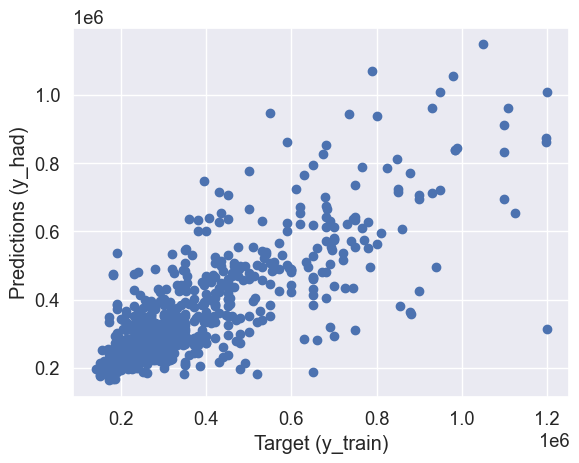

Mean Absolute Error: 78408.6457380993
Mean Squared Error: 14423922895.802183
Root Mean Squared Error: 120099.63736748826
R-squared score 0.4787507470881205
=== LGBMRegressor() ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 2904, number of used features: 5
[LightGBM] [Info] Start training from score 353870.911501


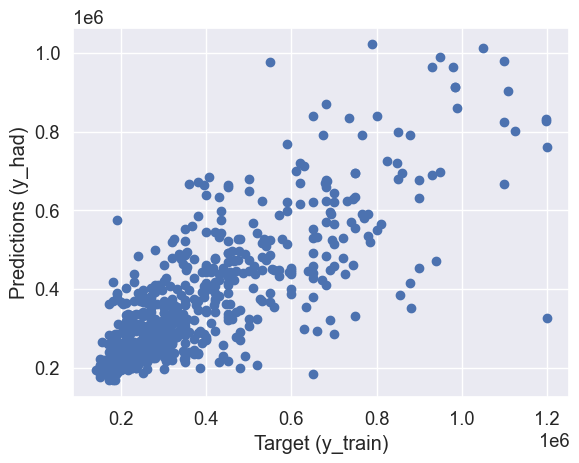

Mean Absolute Error: 78764.40655505458
Mean Squared Error: 14556018368.758482
Root Mean Squared Error: 120648.32518008065
R-squared score 0.44200492417072534


In [151]:
from sklearn import metrics
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

model_list = [ LinearRegression(), 
               RandomForestRegressor(),
               DummyRegressor(strategy="median"),
               CatBoostRegressor(verbose=False),
               LGBMRegressor()
              ]

for m in model_list:
    print("===", m, "===")
    m.fit(X_train, y_train)
    y_hat = m.predict(X_test)
    plt.scatter(y_test, y_hat)
    plt.xlabel('Target (y_train)')
    plt.ylabel('Predictions (y_had)')
    plt.show()
    print("Mean Absolute Error:", metrics.mean_absolute_error(y_hat, y_test))
    print("Mean Squared Error:", metrics.mean_squared_error(y_hat, y_test))
    print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y_hat, y_test)))
    print("R-squared score", metrics.r2_score(y_hat, y_test))